### Importance Sampling

In [1]:
import numpy as np
from   numpy import random
from   scipy import stats
from   functools import reduce
import matplotlib.pyplot as plt
import csv

In [2]:
nsamples = 1000

def meanEstimate(nsamples):
    # Generate samples from proposal distribution
    mu = 0
    sigma = 1
    samples = random.normal(mu, sigma, nsamples)

    # Compute the weights
    wTilde = [(0.25/stats.norm.pdf(sample)) if (sample >= 0) and (sample <=4) else 0 for sample in samples]
    wTildeSum = sum(wTilde)

    # Normalize the weights
    if wTildeSum != 0:
        w = [wTildei/wTildeSum for wTildei in wTilde]
    else:
        w = [0 for wTildei in wTilde]

    meanEst = sum([wi * samples[i] for i, wi in enumerate(w)])
    return meanEst

In [3]:
expmean = 0.0
count = 0
for i in range(10):
    count += 1.0
    expmean = (expmean*(count - 1) + meanEstimate(nsamples))/count
    
print('Expected mean %f' % expmean)

Expected mean 2.023737


### Importance sampling in higher dimensions

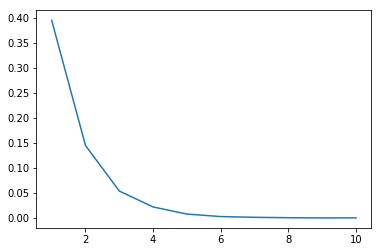

In [4]:
def importancesampling(nsamples,dimension):
    samples = random.multivariate_normal(mean = np.zeros(dimension),cov = np.identity(dimension), size = nsamples)
    wTilde = []
    for sample in samples:
        ok = True
        for dim in range(dimension):
            if sample[dim]<-0.5 or sample[dim]>0.5:
                ok = False
                break
        if ok:
            wTilde.append((1.0/stats.multivariate_normal.pdf(sample, mean=np.zeros(dimension), 
                                                      cov=np.identity(dimension))))
        else:
            wTilde.append(0)
    return wTilde

def do_sum(x1, x2): return x1 + x2

fraction = []
dimensions = 10
for dimension in range(1,dimensions+1):
    nsamples = 10000
    wTilde = importancesampling(nsamples,dimension)
    count = sum(map(lambda x: 1,filter(lambda x: x>0, wTilde)))
    fraction.append(1.0*count/nsamples)

plt.plot(np.linspace(1,dimensions,dimensions),fraction)
plt.show()

### An important numerical aspect

In [5]:
nsamples = 10
dimension = 20
samples = random.multivariate_normal(mean = np.zeros(dimension),cov = 4*np.identity(dimension), size = nsamples)

pix = stats.multivariate_normal.pdf(samples, mean=np.zeros(dimension), cov=np.identity(dimension))
qx = stats.multivariate_normal.pdf(samples, mean=np.zeros(dimension), cov=4*np.identity(dimension))

##### Below returns zero error because the numbers are too small

In [6]:
# Compute the weights
wTilde = [pix[i]/qx[i] for i in range(nsamples)]
wTildeSum = sum(wTilde)

# Normalize the weights
w = [wTildei/wTildeSum for wTildei in wTilde]

print(w)

[8.307650805128471e-10, 0.002173991150768213, 2.2438822397594644e-13, 0.9975969169043878, 8.86315623678036e-05, 1.5207634810637049e-07, 0.00011309107402804286, 2.800465615073712e-06, 6.349421442960826e-08, 2.4352441281166617e-05]


##### Instead we can use the log of the pdf

In [7]:
logwTilde = []
for sample in samples:
    logwTildei = 0
    for dim in range(dimension):
        logwTildei += np.log(stats.norm.pdf(sample[dim],loc = 0, scale = 1)) \
                        - np.log(stats.norm.pdf(sample[dim],loc = 0, scale = 2))
    logwTilde.append(logwTildei)

# normalized weights
wnew = [np.exp(logwTildei - max(logwTilde)) for logwTildei in logwTilde]

print(wnew)

[8.327662870999787e-10, 0.0021792280167768027, 2.2492874644424382e-13, 1.0, 8.884506444028817e-05, 1.5244268053501345e-07, 0.00011336349592876898, 2.807211577762029e-06, 6.364716385314742e-08, 2.4411103190589077e-05]


### Bootstrap particle filter for the stochastic volatility model

In [88]:
theta = [0.98, 0.16, 0.70]
phi, sigma, beta = theta
logreturns = []
with open('seOMXlogreturns2012to2014.csv','rt')as f:
  entries = csv.reader(f)
  for row in entries:
        logreturns.append(float(row[0]))

In [89]:
nparticles = 500
T = len(logreturns)

In [90]:
# initialization
# sample x0
x0 = random.normal(loc=0,scale=sigma,size=nparticles)
# initialize w0
w0 = 1.0/nparticles * np.ones(nparticles)
xbar = [np.mean(x0)]

In [91]:
def sampling(x,freq):
    s = []
    for i, f in enumerate(freq):
        s += f*[x[i]]
    return s

In [92]:
x = [x0]
w = [w0]
for t in range(1,T):
    print('Run for time t = %f' % t, end="\r", flush=True)
    # sample ancestor indices
    freq = random.multinomial(nparticles,w[-1])
    xprev = x[-1]
    xancestor = sampling(xprev,freq)
    xcurr = []
    wtilde = []
    # propagate
    for particle in range(nparticles):
        xcurr.append(random.normal(loc = xancestor[particle]*phi, scale = sigma))
        wtilde.append(stats.norm.pdf(logreturns[t],loc=0,scale=beta*(np.exp(xcurr[particle]))))
    x.append(xcurr)
    xbar.append(np.mean(xcurr))
    # weight
    wcurr = [wtildei/sum(wtilde) for wtildei in wtilde]
    w.append(wcurr)

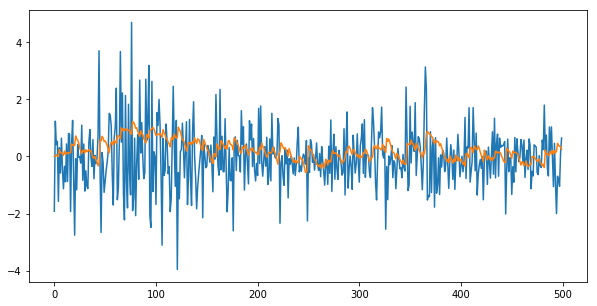

In [95]:
plt.figure(figsize=(10,5))
plt.plot(logreturns,'-')
plt.plot(xbar)
plt.show()

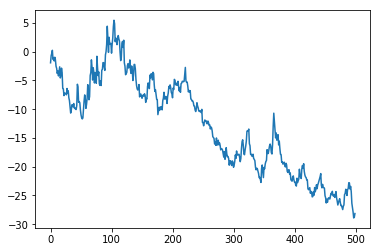

In [76]:
plt.plot(np.cumsum(logreturns))
plt.show()